Adapt from https://anderfernandez.com/en/blog/how-to-code-gan-in-python/

Check for GPU session

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Connect to Google Drive

In [2]:
from google.colab import drive
import os
from datetime import datetime
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Make GAN Generator

In [3]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential

In [4]:
def generator_the_images():

    generator = Sequential()

    generator.add(Dense(512*4*4, input_shape = (100,)))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Reshape((4,4,512)))

    generator.add(Conv2DTranspose(256,kernel_size=4, strides=2, padding = "same"))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(128,kernel_size=4, strides=2, padding = "same"))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(64,kernel_size=4, strides=2, padding = "same"))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(3,kernel_size=4, strides=2, padding = "same", activation='tanh'))

    return(generator)

model_generator = generator_the_images()

model_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        2097408   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1

Load Model if already trained

In [ ]:
# 1. We go to the correct folder in Drive
#from google.colab import drive
#import os
#drive.mount('/content/gdrive/')
%cd /content/gdrive/MyDrive/ProjectOutput/GAN_Fernandez/flowers_pictogram/

# 2. We import the model
from keras.models import load_model

model_generator = load_model('180_20211005_163832_model_generator_.h5')

/content/gdrive/MyDrive/ProjectOutput/GAN_Fernandez/flowers_pictogram


Check generator

In [5]:
import matplotlib.pyplot as plt
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


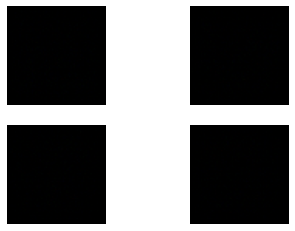

In [6]:
# Checking if the generative network works
def generar_datos_entrada(n_muestras):
  X = np.random.randn(100 * n_muestras)
  X = X.reshape(n_muestras, 100)
  return X

def crear_datos_fake(model_generator, n_muestras):
  input = generar_datos_entrada(n_muestras)
  X = model_generator.predict(input)
  y = np.zeros((n_muestras, 1))
  return X,y

numero_muestras = 4
X,_ = crear_datos_fake(model_generator, numero_muestras)

# Visualizamos result
for i in range(numero_muestras):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])

Make GAN Discriminator

In [7]:
from keras.layers import Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

def discriminator_the_images():

    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=4,strides=(2,2), padding = "same", input_shape = (64,64,3)))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(128, kernel_size=4,strides=(2,2), padding = "same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(256, kernel_size=4,strides=(2,2), padding = "same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(512, kernel_size=4,strides=(2,2), padding = "same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminator)

model_discriminator = discriminator_the_images()
model_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Load data from Cifar10

In [ ]:
from keras.datasets import cifar10

def cargar_imagenes():
    (Xtrain, Ytrain), (_, _) = cifar10.load_data()

    # Nos quedamos con los perros
    indice = np.where(Ytrain == 0)
    indice = indice[0]
    Xtrain = Xtrain[indice, :,:,:]

    # Normalizamos los datos
    X = Xtrain.astype('float32')
    X = (X - 127.5) / 127.5

    return X

print(cargar_imagenes())
print(cargar_imagenes().shape)

Load training data

In [8]:
%cd /content/gdrive/MyDrive/dataset/dataset_npy
dataset = np.load('myButterflies64.npy')
print(dataset.shape)

/content/gdrive/MyDrive/dataset/dataset_npy
(150, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


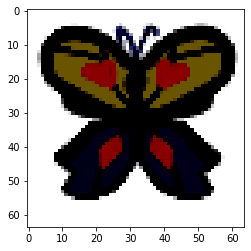

In [9]:
plt.imshow(dataset[32])

Training the discriminator network

In [10]:
import random

def cargar_datos_reales(dataset, n_muestras):
  ix = np.random.randint(0, dataset.shape[0], n_muestras)
  X = dataset[ix]
  y = np.ones((n_muestras, 1))
  return X,y

def cargar_datos_fake(n_muestras):
  X = np.random.rand(64 * 64 * 3 * n_muestras)
  X = -1 + X * 2
  X = X.reshape((n_muestras, 64,64,3))
  y = np.zeros((n_muestras, 1))
  return X,y

In [11]:
def entrenar_discriminador(modelo, dataset, n_iteraciones=20, batch = 128):
  medio_batch = int(batch/2)

  for i in range(n_iteraciones):
    X_real, y_real = cargar_datos_reales(dataset, medio_batch)
    _, acc_real = modelo.train_on_batch(X_real, y_real)

    X_fake, y_fake = cargar_datos_fake(medio_batch)
    _, acc_fake = modelo.train_on_batch(X_fake, y_fake)

    print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))

entrenar_discriminador(model_discriminator, dataset)

1 Real:26.5625, Fake:0.0
2 Real:100.0, Fake:0.0
3 Real:100.0, Fake:40.625
4 Real:100.0, Fake:100.0
5 Real:100.0, Fake:100.0
6 Real:100.0, Fake:100.0
7 Real:100.0, Fake:100.0
8 Real:100.0, Fake:100.0
9 Real:100.0, Fake:100.0
10 Real:100.0, Fake:100.0
11 Real:100.0, Fake:100.0
12 Real:100.0, Fake:100.0
13 Real:100.0, Fake:100.0
14 Real:100.0, Fake:100.0
15 Real:100.0, Fake:100.0
16 Real:100.0, Fake:100.0
17 Real:100.0, Fake:100.0
18 Real:100.0, Fake:100.0
19 Real:100.0, Fake:100.0
20 Real:100.0, Fake:100.0


In [12]:
#Back to directory to save work
%cd /content/gdrive/MyDrive/ProjectOutput/GAN_AFJ/myButterflies/

/content/gdrive/MyDrive/ProjectOutput/GAN_AFJ/myButterflies


Create GAN

In [13]:
def crear_gan(discriminador, generador):
    discriminador.trainable=False
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminador)

    opt = Adam(lr=0.0002,beta_1=0.5) 
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

gan = crear_gan(model_discriminator,model_generator)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         3617987   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 2764737   
                                                                 
Total params: 6,382,724
Trainable params: 3,600,707
Non-trainable params: 2,782,017
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model Evaluate and Image Generate

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

def mostrar_imagenes_generadas(datos_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  # Hacemos que los datos vayan de 0 a 1
  datos_fake = (datos_fake + 1) / 2.0

  output_path = str(epoch)
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  for i in range(10):
    plt.imshow(datos_fake[i])
    plt.axis('off')
    nombre = str(epoch) + '_image_generate_' + str(i) + '.png'
    filename = os.path.join(output_path, nombre)
    plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)
    plt.close()

  fig = plt.figure(figsize=(3, 3))
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(datos_fake[i])
    plt.axis('off')
  filename = 'image_at_epoch_{:04d}.png'.format(epoch)
  plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)
  plt.close

In [15]:
def evaluar_y_guardar(model_generator, epoch, medio_dataset):

  # We save the model
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  nombre = str(epoch) + '_' + str(now)+"_model_generator_" + '.h5'
  model_generator.save(nombre)

  # We generate new data
  X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)
  X_fake, Y_fake =  crear_datos_fake(model_generator,medio_dataset)

  # We evaluate the model
  _, acc_real = model_discriminator.evaluate(X_real, Y_real)
  _, acc_fake = model_discriminator.evaluate(X_fake, Y_fake)

  print('Epoch:' + str(epoch) + ', Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

Time Record

In [16]:
recording = []
def recordTime():
  recording.append(datetime.now())

Create Training Function

In [17]:
def entrenamiento(datos, model_generator, model_discriminator, epochs, n_batch, inicio = 0):
  dimension_batch = int(datos.shape[0]/n_batch)
  medio_dataset = int(n_batch/2)

  # We iterate over the epochs
  for epoch in range(inicio, inicio + epochs):
    # We iterate over all batches
    for batch in range(n_batch):

      # We load all the real data
      X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)


      # We train the discriminator withEnrenamos discriminador con datos reales
      coste_discriminador_real, _ = model_discriminator.train_on_batch(X_real, Y_real)
      X_fake, Y_fake =  crear_datos_fake(model_generator,medio_dataset)

      coste_discriminador_fake, _ = model_discriminator.train_on_batch(X_fake, Y_fake)

      # We generate input images for the GAN
      X_gan = generar_datos_entrada(medio_dataset)
      Y_gan = np.ones((medio_dataset, 1))

      # We train the GAN with fake data
      coste_gan = gan.train_on_batch(X_gan, Y_gan)

    # Every 10 epochs we show the results and cost 
    if (epoch%(int(epochs*25/100)) == 0 and epoch != 0):
      recordTime()
      evaluar_y_guardar(model_generator,epoch = epoch, medio_dataset= medio_dataset)
      mostrar_imagenes_generadas(X_fake, epoch = epoch)

#Train

2/2 [==============================] - 0s 8ms/step - loss: 0.8130 - accuracy: 0.5469
Epoch:25, Acc Real:100.0% Acc Fake:54.6875%
2/2 [==============================] - 0s 7ms/step - loss: 0.6677 - accuracy: 0.6406
Epoch:50, Acc Real:100.0% Acc Fake:64.0625%
2/2 [==============================] - 0s 8ms/step - loss: 0.5098 - accuracy: 0.7969
Epoch:75, Acc Real:100.0% Acc Fake:79.6875%
2/2 [==============================] - 0s 8ms/step - loss: 0.5293 - accuracy: 0.7969
Epoch:100, Acc Real:96.875% Acc Fake:79.6875%
/content/gdrive/MyDrive/ProjectOutput/TimeRecord
(8, 0)
(16, 1)
(24, 2)
(32, 4)


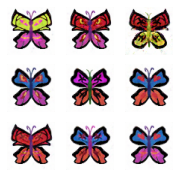

In [18]:
#Train GAN
recordTime()
entrenamiento(dataset, model_generator, model_discriminator, epochs = 100, n_batch=128, inicio = 1)

#move to folder for save
%cd /content/gdrive/MyDrive/ProjectOutput/TimeRecord/

outputRecordName = 'myButterflies'
outputGANName = 'AFJ'

timeName = outputRecordName + '_' + outputGANName + '_TimeRecord.npy'
np.save(timeName, recording)

#calculate time difference
timeCal = []
for i in range(4):
  difference = recording[i+1] - recording[0]
  seconds_in_day = 24 * 60 * 60
  diff = divmod(difference.days * seconds_in_day + difference.seconds, 60)
  print(diff)
  timeCal.append(diff)

timeCalName = outputRecordName + '_' + outputGANName + '_TimeDiffRecord.npy'
np.save(timeCalName, timeCal)

See the images

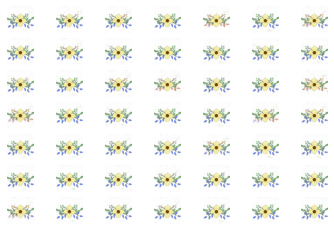

In [ ]:
X_fake, _ = crear_datos_fake(n_muestras=59, model_generator=model_generator)
X_fake = (X_fake+1)/2

for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X_fake[i])